# Cell 1 — # Theme Extraction — Visualizations
Load TF-IDF + LDA outputs and visualize themes & create wordclouds per bank.


Cell 2 — Imports & style

In [1]:
# Cell 2: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import os
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120


# Cell 3 — Load themes & LDA outputs

In [2]:
# Cell 3: Load theme outputs (adjust paths if necessary)
themes_path = "../data/themes/themes_by_bank.csv"
lda_path = "../data/themes/lda_topics_by_bank.csv"

themes_df = pd.read_csv(themes_path)
lda_df = pd.read_csv(lda_path)

print("Themes rows:", len(themes_df))
display(themes_df.head())

print("LDA rows:", len(lda_df))
display(lda_df.head())


Themes rows: 3


,bank_code,bank_name,keywords,themes
0,BOA,Bank of Abyssinia,"app, application, apps, bad, bank, banking, ba...","Performance & Reliability, User Interface & Ex..."
1,CBE,Commercial Bank of Ethiopia,"account, app, application, apps, bad, bank, ba...","Account Access Issues, User Interface & Experi..."
2,Dashen,Dashen Bank,"amazing, app, application, bank, banking, bank...","Performance & Reliability, User Interface & Ex..."


LDA rows: 12


,bank_code,bank_name,topic_number,topic_keywords
0,BOA,Bank of Abyssinia,1,"app, working, bank, fix, time, application, mo..."
1,BOA,Bank of Abyssinia,2,"app, good, best, bank, boa, worst, work, banking"
2,BOA,Bank of Abyssinia,3,"app, use, nice, developer, like, experience, o..."
3,BOA,Bank of Abyssinia,4,"great, money, work, doesn, app, fast, applicat..."
4,CBE,Commercial Bank of Ethiopia,1,"app, excellent, transaction, banking, cbe, upd..."


# Cell 4 — Pretty display of themes (table)

In [3]:
# Cell 4: Show themes in a readable dataframe (split keywords)
themes_df["keywords_preview"] = themes_df["keywords"].str.replace(",", ", ")
display(themes_df[["bank_code","bank_name","themes","keywords_preview"]])


,bank_code,bank_name,themes,keywords_preview
0,BOA,Bank of Abyssinia,"Performance & Reliability, User Interface & Ex...","app, application, apps, bad, bank, bankin..."
1,CBE,Commercial Bank of Ethiopia,"Account Access Issues, User Interface & Experi...","account, app, application, apps, bad, ban..."
2,Dashen,Dashen Bank,"Performance & Reliability, User Interface & Ex...","amazing, app, application, bank, banking, ..."


# Cell 5 — Theme counts bar chart

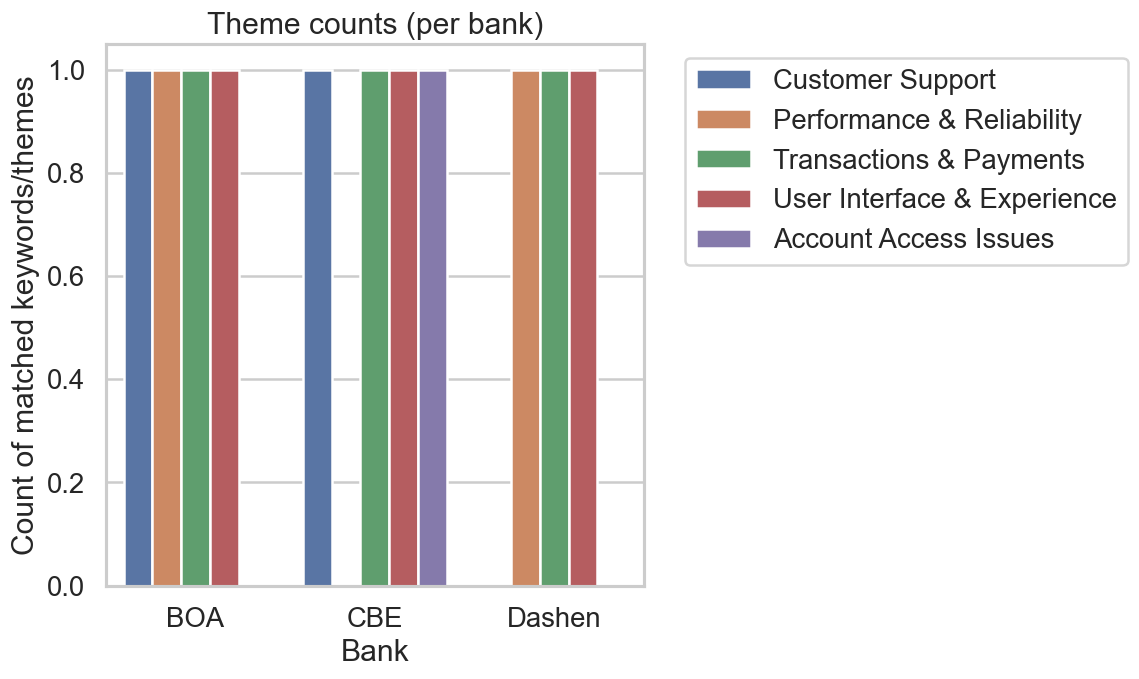

In [4]:
# Cell 5: Expand themes into rows and count them
# If themes column contains comma-separated themes per bank
expanded = themes_df.set_index(["bank_code","bank_name"])["themes"].str.split(", ").explode().reset_index()
count = expanded.groupby(["bank_code","themes"]).size().reset_index(name="count")

plt.figure(figsize=(10,6))
sns.barplot(data=count, x="bank_code", y="count", hue="themes")
plt.title("Theme counts (per bank)")
plt.xlabel("Bank")
plt.ylabel("Count of matched keywords/themes")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


# Cell 6 — LDA topics table (nice):

In [5]:
# Cell 6: Show LDA topics grouped
for bank in lda_df["bank_code"].unique():
    print("\n" + "="*40)
    print(f"Bank: {bank}")
    display(lda_df[lda_df["bank_code"]==bank].sort_values("topic_number"))



Bank: BOA


,bank_code,bank_name,topic_number,topic_keywords
0,BOA,Bank of Abyssinia,1,"app, working, bank, fix, time, application, mo..."
1,BOA,Bank of Abyssinia,2,"app, good, best, bank, boa, worst, work, banking"
2,BOA,Bank of Abyssinia,3,"app, use, nice, developer, like, experience, o..."
3,BOA,Bank of Abyssinia,4,"great, money, work, doesn, app, fast, applicat..."



Bank: CBE


,bank_code,bank_name,topic_number,topic_keywords
4,CBE,Commercial Bank of Ethiopia,1,"app, excellent, transaction, banking, cbe, upd..."
5,CBE,Commercial Bank of Ethiopia,2,"best, app, nice, bank, txn, fast, connect, cbe"
6,CBE,Commercial Bank of Ethiopia,3,"good, app, update, love, great, time, new, bank"
7,CBE,Commercial Bank of Ethiopia,4,"app, cbe, like, bank, service, bad, friendly, ..."



Bank: Dashen


,bank_code,bank_name,topic_number,topic_keywords
8,Dashen,Dashen Bank,1,"app, best, nice, amazing, bank, application, o..."
9,Dashen,Dashen Bank,2,"app, wow, slow, bank, convenient, love, use, new"
10,Dashen,Dashen Bank,3,"app, dashen, banking, super, bank, fast, easy,..."
11,Dashen,Dashen Bank,4,"good, app, worst, time, banking, experience, r..."


# Cell 7 — Wordcloud per bank (beautiful layout)

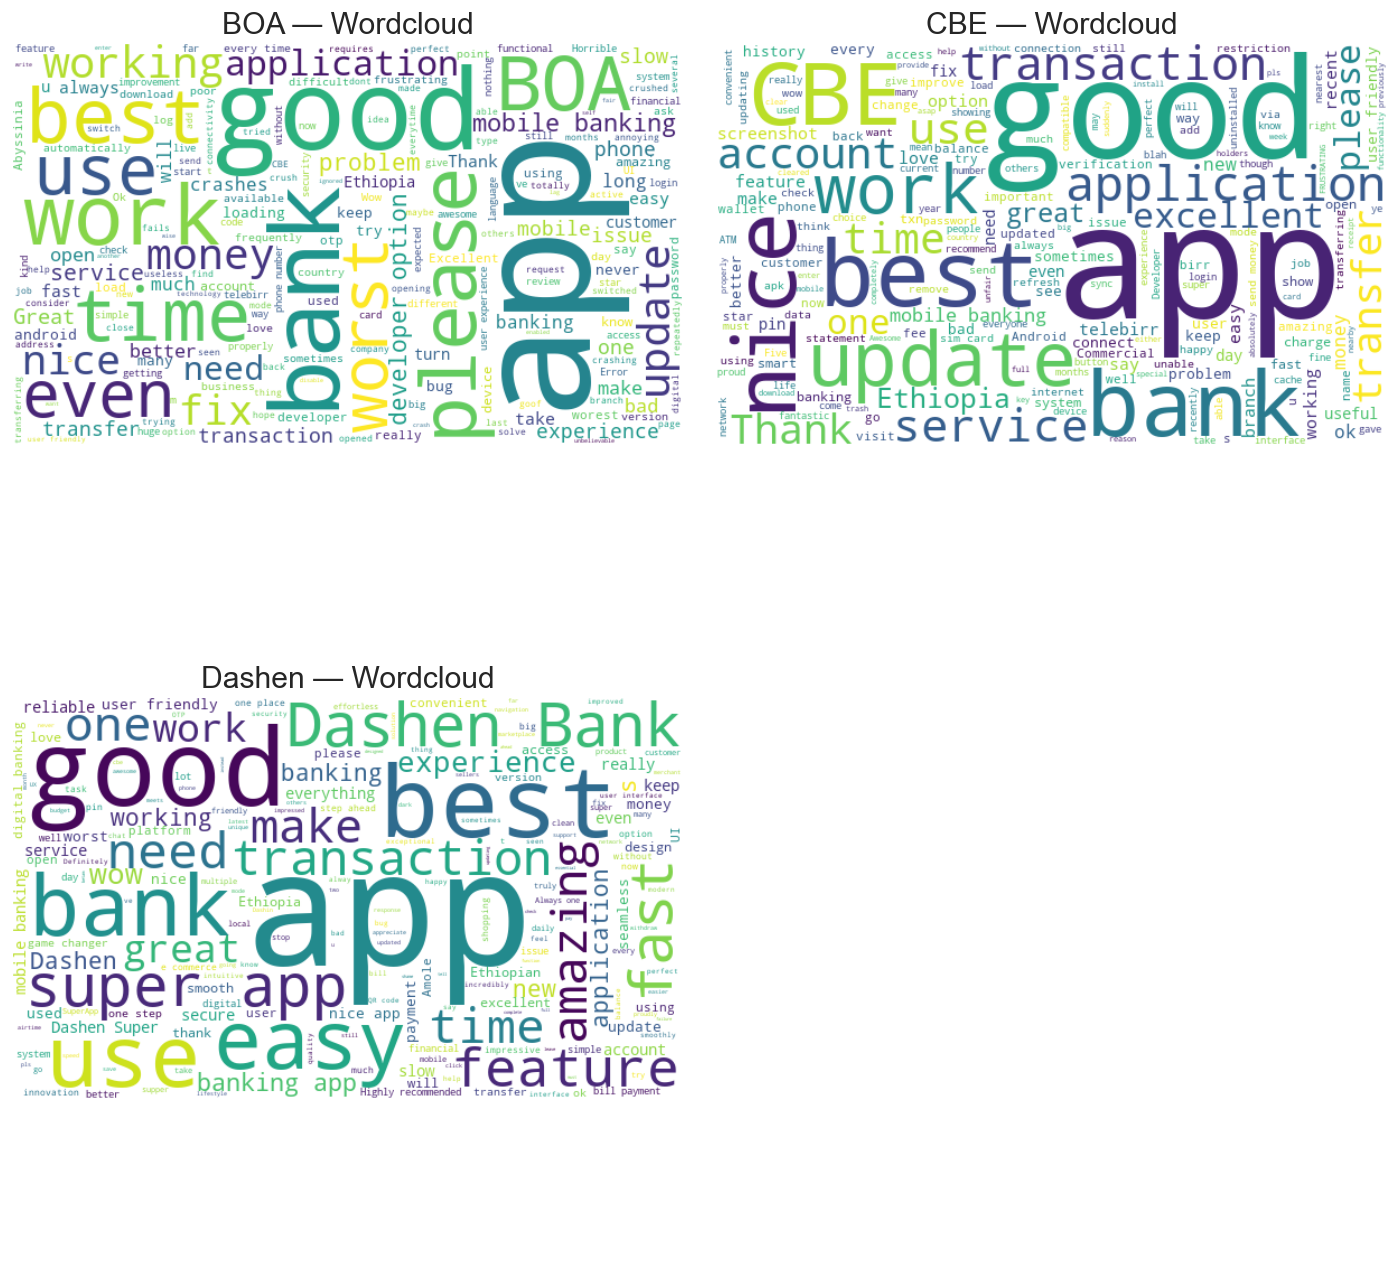

In [6]:
# Cell 7: Build wordclouds using the raw reviews (if available) OR keywords
# Prefer using review text if available: try to load processed reviews
processed_path = "data/processed/reviews_processed.csv"
if os.path.exists(processed_path):
    rev = pd.read_csv(processed_path)
    rev["review_text"] = rev["review_text"].astype(str)
else:
    # fallback: create synthetic text from keywords in themes_df
    rev = None
    themes_df["text_for_wc"] = themes_df["keywords"].fillna("").str.replace(",", " ")

# Function to create cloud
def make_wc(text, title, ax):
    wc = WordCloud(width=600, height=360, background_color="white",
                   collocations=True, stopwords=set(STOPWORDS)).generate(text)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(title)
    ax.axis("off")

# Create one panel per bank
banks = themes_df["bank_code"].unique()
n = len(banks)
cols = min(2, n)
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
axes = axes.flatten() if n>1 else [axes]

for i, bank in enumerate(banks):
    ax = axes[i]
    if rev is not None:
        bank_text = " ".join(rev[rev["bank_code"]==bank]["review_text"].astype(str).values[:1000])
        if not bank_text.strip():
            bank_text = " ".join(themes_df[themes_df["bank_code"]==bank]["keywords"].fillna("").values)
    else:
        bank_text = " ".join(themes_df[themes_df["bank_code"]==bank]["text_for_wc"].values)
    make_wc(bank_text, f"{bank} — Wordcloud", ax)

# hide extra axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# Cell 8: TF-IDF Representation & Top Keywords Extraction

In [9]:
# Cell: TF-IDF representation for theme extraction

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load sentiment file (or processed file)
df = pd.read_csv("../data/sentiment/sentiment_results.csv")

print("Loaded rows:", len(df))

# Ensure text column exists
df['review_text'] = df['review_text'].fillna("")

# Group by bank
banks = df['bank_name'].unique()
banks


Loaded rows: 1463


array(['Bank of Abyssinia', 'Commercial Bank of Ethiopia', 'Dashen Bank'],
      dtype=object)

# Cell 2 — Define get_top_keywords() 

In [12]:
import numpy as np

def get_top_keywords(corpus, n=20):
    """
    Extract top n TF-IDF keywords from a list of documents.
    """
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),   # unigrams + bigrams
        max_df=0.85,
        min_df=2
    )

    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Average TF-IDF score for each term
    mean_scores = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_scores.argsort()[-n:][::-1]

    return [(feature_names[i], mean_scores[i]) for i in top_indices]


# Cell 10: TF-IDF Function to Get Top Keywords Per Bank

In [15]:
# Cell: Generate TF-IDF keywords per bank

tfidf_results = []

for bank in banks:
    bank_reviews = df[df["bank_name"] == bank]["review_text"].tolist()
    
    if len(bank_reviews) < 5:
        print(f"Skipping {bank} — Not enough reviews.")
        continue
    
    top_kw = get_top_keywords(bank_reviews, n=15)
    
    for word, score in top_kw:
        tfidf_results.append({
            "bank_name": bank,
            "keyword": word,
            "tfidf_score": score
        })

tfidf_df = pd.DataFrame(tfidf_results)
tfidf_df.head(20)


,bank_name,keyword,tfidf_score
0,Bank of Abyssinia,good,0.121169
1,Bank of Abyssinia,app,0.082520
2,Bank of Abyssinia,best,0.040029
3,Bank of Abyssinia,nice,0.028979
4,Bank of Abyssinia,boa,0.026399
5,Bank of Abyssinia,bank,0.026040
6,Bank of Abyssinia,work,0.020109
7,Bank of Abyssinia,working,0.020017
8,Bank of Abyssinia,great,0.018179
9,Bank of Abyssinia,like,0.018095


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 

# Cell 4 — Save

In [16]:
output_path = "../data/themes/tfidf_keywords.csv"
tfidf_df.to_csv(output_path, index=False)

print("Saved:", output_path)


Saved: ../data/themes/tfidf_keywords.csv
